<a href="https://colab.research.google.com/github/bhardwajshivam/Gemma-PET/blob/main/Parameter_efficient_tuning_Gemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter Efficient Tuning - Gemma

This notebook illustrates how to create a customised text classifier using parameter efficient tuning (PET). Instead of fine-tuning the whole model, PET methods update only a small amount of parameters, which makes it relatively easy and fast to train. It also makes it easier for a model to learn new behaviors with relatively little training data.

This notebook uses the LoRA PET method and the smaller Gemma model (gemma_instruct_2b_en) since that can be run faster and more efficiently.

The colab covers the steps of ingesting data, formatting it for the LLM, training LoRA weights, and then evaluating the results. This notebook trains on the ETHOS dataset, a publicly available dataset for detecting hateful speech, built from YouTube and Reddit comments. When trained on only 200 examples (1/4 of the dataset) it achieves F1: 0.80 and ROC-AUC: 0.78, slightly above the SOTA currently reported on the leaderboard (at the time of writing, 15 Feb 2024). When trained on the full 800 examples, like it achieves an F1 score of 83.74 and a ROC-AUC score of 88.17.

In [2]:
# Setup

import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
!pip install -q -U keras-nlp
!pip install -q -U keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

# Loading the ETHOS dataset

We will use the popular research dataset ETHOS which was collected to detect hate speech in social media.

In [5]:
import pandas as pd

gh_root = 'https://raw.githubusercontent.com'
gh_repo = 'intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset'
gh_path = 'master/ethos/ethos_data/Ethos_Dataset_Binary.csv'
data_url = f'{gh_root}/{gh_repo}/{gh_path}'

df = pd.read_csv(data_url, delimiter=';')
df['hateful'] = (df['isHate'] >= df['isHate'].median()).astype(int)

# Shuffle the dataset.
df = df.sample(frac=1, random_state=32)

# Split into train and test.
df_train, df_test = df[:800],  df[800:]

# Display a sample of the data.
df.head(5)[['hateful', 'comment']]

,hateful,comment
517,0,You said he but still not convinced this is a ...
685,0,"well, looks like its time to have another child"
706,0,to be honest I am part of the LGBT community a...
182,1,What if we send every men to mars to start a n...
829,0,"It doesn't matter if you're black or white, ..."


## Downloading and Instanciating the Gemma Model

In [6]:
import keras
import keras_nlp

# For reproducibility purposes.
keras.utils.set_random_seed(2024)

# Download the model from Kaggle using Keras.
model = keras_nlp.models.GemmaCausalLM.from_preset('gemma_instruct_2b_en')

# Set the sequence length to a small enough value to fit in memory in Colab.
model.preprocessor.sequence_length = 128

Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Colab notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Colab notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Colab notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Colab notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Colab notebook...


In [7]:
model.generate('Question: what is the capital of the United States of America? ', max_length=32)

'Question: what is the capital of the United States of America? \n\nAnswer: Washington, D.C.\n\nExplanation: The capital of the United'

## Text Preprocessing and Separator Tokens
To help the model understand our intent better, you can preprocess the text and use separator tokens. This makes it less likely for the model to generate text that does not fit the expected format. For example, you might attempt to request a sentiment classification from the model by writing a prompt like this:

Classify the following text into one of the following classes:[Positive,Negative]

Text: you look very nice today
Classification:
In this case, the model may or may not output what you are looking for. For example, if the text contains newline characters, it's likely to have a negative effect on the model performance. A more robust approach is to use separator tokens. The prompt then becomes:

Classify the following text into one of the following classes:[Positive,Negative]
<separator>
Text: you look very nice today
<separator>
Prediction:
This can be abstracted using a function that preprocesses the text:

In [8]:
def preprocess_text(text: str,labels: list[str],instructions: str,separator: str) -> str:
  prompt = f'{instructions}:[{",".join(labels)}]'
  return separator.join([prompt, f'Text:{text}', 'Predictions'])

# Now, if you run the function using the same prompt and text as before, you should get the same output:

text = 'you look very nice today'

prompt = preprocess_text(
    text=text,
    labels=['Positive', 'Negative'],
    instructions='Classify the following text into one of the following classes',
    separator='\n\n',
)

print(prompt)

Classify the following text into one of the following classes:[Positive,Negative]

Text:you look very nice today

Predictions


## Output Postprocessing

The outputs of the model are tokens with various probabilities. Normally, to generate text, we select among the top few most probable tokens and construct sentences, paragraphs or even full documents. However, for the purpose of classification, what actually matters is whether the model believes that Positive is more probable than Negative or vice versa.

Given the model you instantiated earlier, this is how you can process its output into the independent probabilities of whether the next token is Positive or Negative, respectively:

In [9]:
import numpy as np


def softmax_normalization(arr: np.ndarray) -> np.ndarray:
  """Normalizes logits values into probabilities summing to one."""
  arr_exp = np.exp(arr - np.max(arr))
  return arr_exp / arr_exp.sum()


def compute_token_probability(
    model: keras_nlp.models.GemmaCausalLM,
    prompt: str,
    target_tokens: list[str],
) -> dict[str, float]:
  # Shorthands.
  preprocessor = model.preprocessor
  tokenizer = preprocessor.tokenizer

  # Identify output token offset.
  (padding_mask,) = preprocessor.generate_preprocess([prompt])['padding_mask']
  token_offset = sum(padding_mask.numpy()) - 1

  # Compute prediction, extract only the next token's logits.
  (logits,) = model.predict([prompt], verbose=0)
  token_logits = logits[token_offset]

  # Identify the token indices, which is the same as the ID for this tokenizer.
  # NOTE: If a token is not found, it will be considered same as "".
  token_ids = [tokenizer.token_to_id(token) for token in target_tokens]

  # Compute the relative probability of each of the requested tokens.
  probabilities = softmax_normalization([token_logits[ix] for ix in token_ids])

  return dict(zip(target_tokens, probabilities))


In [10]:
compute_token_probability(
    model=model,
    prompt=prompt,
    target_tokens=['Positive', 'Negative'],
)

{'Positive': 0.96720505, 'Negative': 0.032794956}

## Wrapping up the classifier

In [11]:
import dataclasses


@dataclasses.dataclass(frozen=True)
class AgileClassifier:
  """Agile classifier to be wrapped around a LLM."""

  # The classes whose probability will be predicted.
  labels: tuple

  # Provide default instructions and control tokens, can be overridden by user.
  instructions: str = 'Classify the following text into one of the following classes'
  separator_token: str = ''
  end_of_text_token: str = ''

  def encode_for_prediction(self, x_text: str) -> str:
    return preprocess_text(
        text=x_text,
        labels=self.labels,
        instructions=self.instructions,
        separator=self.separator_token,
    )

  def encode_for_training(self, x_text: str, y: int) -> str:
    return ''.join([
        self.encode_for_prediction(x_text),
        self.labels[y],
        self.end_of_text_token,
    ])

  def predict_score(
      self,
      model: keras_nlp.models.GemmaCausalLM,
      x_text: str,
  ) -> list[float]:
    prompt = self.encode_for_prediction(x_text)
    token_probabilities = compute_token_probability(
        model=model,
        prompt=prompt,
        target_tokens=self.labels,
    )
    return [token_probabilities[token] for token in self.labels]

  def predict(
      self,
      model: keras_nlp.models.GemmaCausalLM,
      x_eval: str,
  ) -> int:
    return np.argmax(self.predict_score(model, x_eval))

agile_classifier = AgileClassifier(labels=('Positive', 'Negative'))

## Fine-tuning our model using LoRA

LoRA - Low-Rank Adaptation. It's a fine-tuning technique that can be used to efficiently fine-tune large language models.

In [12]:
# Enable LoRA for the model and set the LoRA rank to 4.
model.backbone.enable_lora(rank=4)

In [13]:
import tensorflow as tf

# Creating a dataset with preprocessed text + labels.
map_fn = lambda x: agile_classifier.encode_for_training(*x)
x_train = list(map(map_fn, df_train[['comment', 'hateful']].values))
ds_train = tf.data.Dataset.from_tensor_slices(x_train).batch(2)

# Compile the model using the Adam optimizer and appropriate loss function.
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Begin training.
model.fit(ds_train, epochs=4)


Epoch 1/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 373s 766ms/step - loss: 1.0480 - sparse_categorical_accuracy: 0.5383
Epoch 2/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 311s 778ms/step - loss: 0.7562 - sparse_categorical_accuracy: 0.6077
Epoch 3/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 322s 777ms/step - loss: 0.6679 - sparse_categorical_accuracy: 0.6404
Epoch 4/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 311s 777ms/step - loss: 0.5974 - sparse_categorical_accuracy: 0.6680


## Observations/Results

In [14]:
text = 'you look really nice today'
scores = agile_classifier.predict_score(model, text)
dict(zip(agile_classifier.labels, scores))

{'Positive': 0.99894756, 'Negative': 0.0010525044}

## Model Evaluation

Finally, we'll evaluate the performance of our model using two common metrics, the F1 score and the AUC-ROC. The F1 score captures false negative and false positive errors by evaluating the harmonic mean of the precision and recall at a certain classification threshold. The AUC-ROC on the other hand captures the tradeoff between the true positive rate and the false positive rate across a variety of thresholds and computes the area under this curve.

In [15]:

y_true = df_test['hateful'].values
# Compute the scores (aka probabilities) for each of the labels.
y_score = [agile_classifier.predict_score(model, x) for x in df_test['comment']]
# The label with highest score is considered the predicted class.
y_pred = np.argmax(y_score, axis=1)
# Extract the probability of a comment being considered hateful.
y_prob = [x[agile_classifier.labels.index('Negative')] for x in y_score]

In [16]:
from sklearn.metrics import f1_score, roc_auc_score

print(f'F1: {f1_score(y_true, y_pred):.2f}')
print(f'AUC-ROC: {roc_auc_score(y_true, y_prob):.2f}')

F1: 0.85
AUC-ROC: 0.87


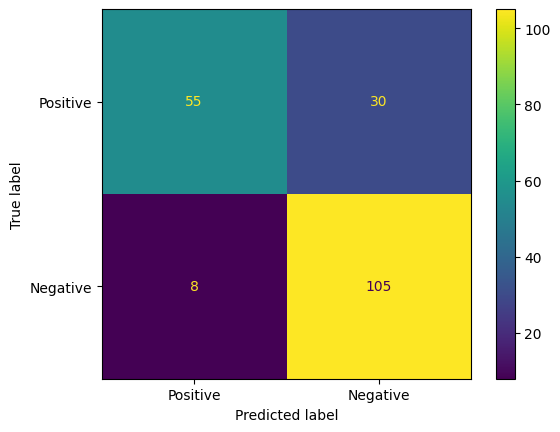

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=agile_classifier.labels,
).plot()


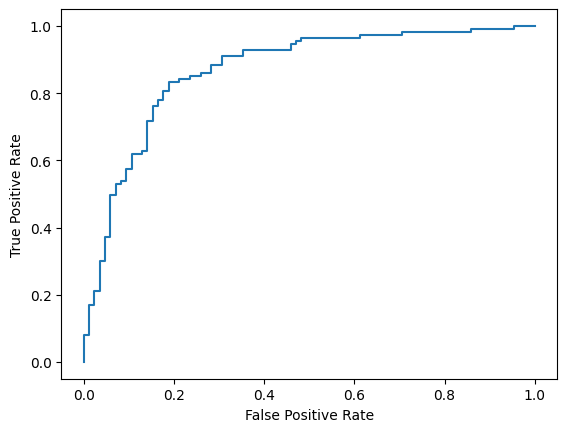

In [18]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()